In [ ]:
!pip install -q transformers timm

!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.5 MB/s eta 0:00:00


In [ ]:
import os
import shutil

# Rimuovi la directory 'dataset' se esiste
if os.path.exists('dataset'):
    shutil.rmtree('dataset')

# Elimina tutti i file ZIP esistenti
zip_files = [f for f in os.listdir() if f.startswith('vehicles.zip')]
for f in zip_files:
    os.remove(f)

# Clona il repository
!git clone https://github.com/glacialfire/dataset.git

# Scarica il file ZIP usando il link raw
!wget https://github.com/glacialfire/dataset/raw/master/vehicles.zip -O vehicles.zip

# Decomprimere il file ZIP
!unzip vehicles.zip > /dev/null

Cloning into 'dataset'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 656 (delta 0), reused 3 (delta 0), pack-reused 653
Receiving objects: 100% (656/656), 48.79 MiB | 24.38 MiB/s, done.
Resolving deltas: 100% (11/11), done.
--2024-07-18 08:43:10--  https://github.com/glacialfire/dataset/raw/master/vehicles.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glacialfire/dataset/master/vehicles.zip [following]
--2024-07-18 08:43:10--  https://raw.githubusercontent.com/glacialfire/dataset/master/vehicles.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

In [ ]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, train=True):
        ann_file = os.path.join(img_folder, "instances_train2017.json" if train else "instances_val2017.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [1]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("microsoft/conditional-detr-resnet-50")

train_dataset = CocoDetection(img_folder='/content/vehicles/train2017', image_processor=image_processor)
val_dataset = CocoDetection(img_folder='/content/vehicles/val2017', image_processor=image_processor, train=False)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


NameError: name 'CocoDetection' is not defined

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 878
Number of validation examples: 250


Image n°824


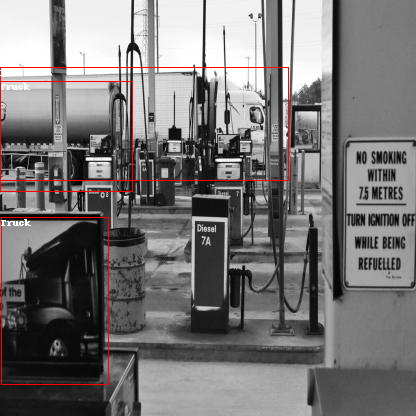

In [ ]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/vehicles/train2017', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = image_processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [ ]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [ ]:
pixel_values, target = train_dataset[0]


pixel_values.shape

print(target)

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([3, 3, 3, 3, 3, 3]), 'boxes': tensor([[0.2350, 0.5883, 0.0805, 0.0421],
        [0.3263, 0.5962, 0.0901, 0.0529],
        [0.4099, 0.5925, 0.0649, 0.0505],
        [0.5024, 0.6034, 0.0769, 0.0577],
        [0.6226, 0.6118, 0.0769, 0.0553],
        [0.9471, 0.6280, 0.1010, 0.0493]]), 'area': tensor([2168.0842, 3051.0354, 2096.8936, 2840.2366, 2721.8936, 3184.1716]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0]), 'orig_size': tensor([416, 416])}


In [ ]:
import pytorch_lightning as pl
from transformers import AutoModelForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("microsoft/conditional-detr-resnet-50",
                                                             id2label={0:"vehicles", 1:"Ambulance", 2:"Bus", 3:"Car", 4:"Motorcycle", 5:"Truck"},
                                                             label2id={"vehicles":0, "Ambulance":1, "Bus":2, "Car":3, "Motorcycle":4, "Truck":5},
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([6]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
outputs.logits.shape

torch.Size([2, 300, 6])

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(max_steps=900, gradient_clip_val=0.1)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                              | Params | Mode
-------------------------------------------------------------------
0 | model | ConditionalDetrForObjectDetection | 43.4 M | eval
-------------------------------------------------------------------
43.2 M    Trainable params
222 K     Non-trainable params
43.4 M    Total params
173.586   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=900` reached.


In [ ]:
! git clone https://github.com/facebookresearch/detr.git
%cd /content/detr

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265
Receiving objects: 100% (265/265), 21.19 MiB | 18.72 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/detr


In [ ]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

In [ ]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized

    # forward pass
    outputs = model.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, threshold=0, target_sizes=orig_target_sizes)
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/125 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.33s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.666
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.551
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.721
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.240
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

torch.Size([1, 3, 800, 800])


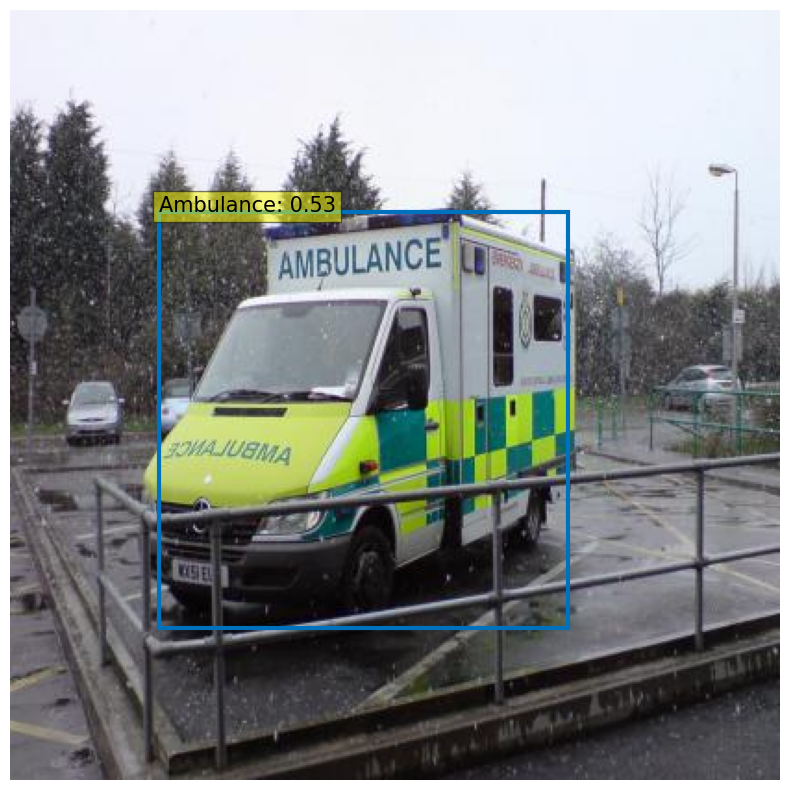

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[1]


image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/content/vehicles/val2017', image['file_name']))


pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)


torch.Size([1, 3, 1066, 800])


# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)


import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


import torch

# rescale bounding boxes
target_sizes = torch.tensor(image.size[::-1], device=device).unsqueeze(0)
results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]


plot_results(image, results['scores'], results['labels'], results['boxes'])